# Compute Entropy During Experiment in Middle Temporal Gyrus R & L 

Hypothesis: Entropy should decrease whenever subject makes a decision (movement onset event)

Subjects with a channel in **Middle Temporal Gyrus L**: 06, 13, 16, 17, 18, 21

Subjects with a channel in **Middle Temporal Gyrus R**: 07, 10, 12, 15, 16

In [2]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# subs = ['06', '13', '16', '17', '18', '21']
subs = ['13']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
    }

In [4]:
raw_file = h5py.File(file_paths[sub]['raw_path'])
setup_data = mat73.loadmat(file_paths[sub]['setup_path'])

In [5]:
elec_names = np.asarray(setup_data['elec_name'])
elec_areas = np.asarray(setup_data['elec_area'])

Fs = raw_file['Fs'][0][0]

In [6]:
from helper_functions import laplacian_reference

lap_ref_data = laplacian_reference(elec_names, Fs, raw_file)

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

In [7]:
selected_ch_idxs = []

for i, area in enumerate(elec_areas):
    if area == 'middle temporal gyrus L':
        selected_ch_idxs.append(i)

In [8]:
good_trials = setup_data['filters']['trial'][setup_data['filters']['success']].astype(int)-1
dsFs = 500

start_trial_index_per_trial = []

start_time = setup_data['trial_times'][0][0][setup_data['trial_words'][0][0]==9][0]
start_index = int(start_time *dsFs)

end_time = setup_data['trial_times'][-1][0][setup_data['trial_words'][-1][0]==18][0]
end_index = int(end_time *dsFs)

for i,t in enumerate(good_trials):
    start_trial_time = setup_data['trial_times'][t][0][setup_data['trial_words'][t][0]==9][0]
    #print(f'start move time = {start_move_time} for trial {t}')
    
    ## To go from the time to the index position in the lfp array, multiply time by Fs 
    start_trial_index_per_trial.append(int(start_trial_time*dsFs))

start_trial_index_per_trial = np.asarray(start_trial_index_per_trial)

In [9]:
bets = setup_data['filters']['bets'][good_trials]
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [10]:
start_trial_index_per_trial

array([ 47613,  56532,  61949,  67158,  72386,  77484,  83033,  88366,
        93835,  98972, 104189, 110102, 114859, 119817, 125183, 130365,
       135635, 140841, 145825, 150582, 155327, 160424, 165362, 170136,
       175716, 181667, 187123, 192730, 197997, 203649, 208392, 214028,
       219131, 223761, 228488, 233348, 238295, 243132, 248452, 253798,
       258843, 264124, 269597, 275043, 280686, 285455, 290349, 295168,
       300502, 305397, 310942, 315409, 320202, 324740, 329768, 336689,
       341756, 346936, 352545, 357324, 362692, 367897, 373395, 377998,
       382671, 387556, 393361, 398014, 402781, 407975, 413673, 419227,
       424380, 429288, 434540, 440081, 445511, 450661, 455600, 460596,
       465169, 470079, 475812, 480666, 485425, 490046, 495175, 499835,
       504956, 510121, 515685, 524002, 528768, 533746, 538921, 545425,
       549924, 555567, 561845, 566971, 572361, 578465, 583260, 588713,
       593762, 599641, 605008, 610294, 615439, 620048, 624681, 630296,
      

In [11]:
rescaled_start_trial_index_per_trial = start_trial_index_per_trial - start_index
data = lap_ref_data[selected_ch_idxs, start_trial_index_per_trial[0]:end_index]
selected_ch_names = elec_names[selected_ch_idxs]

print(lap_ref_data.shape)
print(data.shape)

(133, 1166500)
(11, 893083)


In [12]:
def estimateA(X):
    # Jeff Craley's Method using definition of least squares
    Y = X[:, 1:]
    Z = X[:, 0:-1]
    A_hat = Y @ np.linalg.pinv(Z)
    return A_hat

def estimateA_subject(data, fs=1000, winsize=0.5):
    window = int(np.floor(winsize * fs))
    time = data.shape[1]
    n_chs = data.shape[0]
    n_wins = int(np.round(time / window))
    A_hat = np.zeros((n_chs, n_chs, n_wins))    # elif subject_cards[i] == 10:
    #     c = "red"
    for win in range(0,n_wins):
        if win*window < data.shape[1]:
            data_win = data[:,win*window:(win+1)*window]
            A_hat[:,:,win] = estimateA(data_win)
            if win % 1000 == 0:
                print(f"{win}/{n_wins} is computed")
    return A_hat

In [13]:
window = int(np.floor(0.5 * dsFs))
rescaled_start_trial_index_per_trial = np.round(rescaled_start_trial_index_per_trial / window).astype(int)

In [14]:
A_hat = estimateA_subject(data, fs=dsFs)

0/3572 is computed
1000/3572 is computed
2000/3572 is computed
3000/3572 is computed


In [15]:
def identifySS(A):
    nCh = A.shape[0]

    A_abs = np.abs(A)
    A_abs[np.diag_indices_from(A)] = 0# set diagonals to zero

    # Compute row and column sums
    sum_A_r = np.sum(A_abs,axis=1)
    sum_A_c = np.sum(A_abs,axis=0)

    # Identify sources/sinks
    # Rank the channels from lowest (rank 1) to highest (rank nCh) based on row sum. Rank the channels from highest (rank 1) to
    # lowest (rank nCh) based on column sum. Sum the two ranks. Sinks = high rank sum and sources = low rank sum
    sort_ch_r = np.argsort(sum_A_r) # ascending
    row_ranks = np.argsort(sort_ch_r)  # rearrange the sorted channels back to being from 1:nCh
    row_ranks = row_ranks / nCh

    sort_ch_c = np.argsort(sum_A_c)[::-1] # descending
    col_ranks = np.argsort(sort_ch_c)   # rearrange the sorted channels back to being from 1:nCh
    col_ranks = col_ranks / nCh

    SI = np.sqrt(2) - np.sqrt((1-row_ranks)**2+(1-col_ranks)**2)

    return SI, row_ranks, col_ranks


In [16]:
A_hat.shape

(11, 11, 3572)

In [17]:
# Define variables
winSize_sec = 0.5
nWin = A_hat.shape[2]
nCh = A_hat.shape[0]
sink_row = 1
sink_col = 1
winSize = winSize_sec*dsFs

SI_wins = np.zeros((nCh, nWin))
row_ranks = np.zeros((nCh, nWin))
col_ranks = np.zeros((nCh, nWin))
for iW in range(0,nWin):
    A_win = A_hat[:,:,iW]
    SI_wins[:, iW], row_ranks[:, iW], col_ranks[:, iW] = identifySS(A_win)

In [18]:
SI_wins.shape

(11, 3572)

In [19]:
# Computer A_mean over time wins

A_mean = np.mean(A_hat, axis=2)
SI_overall, _, _ = identifySS(A_mean)
SI_sort_idx_overall = np.argsort(SI_overall)
SI_wins_sorted = SI_wins[SI_sort_idx_overall, :]
labels_sort = [selected_ch_names[i] for i in SI_sort_idx_overall]

In [20]:
SI_wins_sorted.shape

(11, 3572)

Text(0.5, 1.0, 'Sink-Source Index over Entire Experiment')

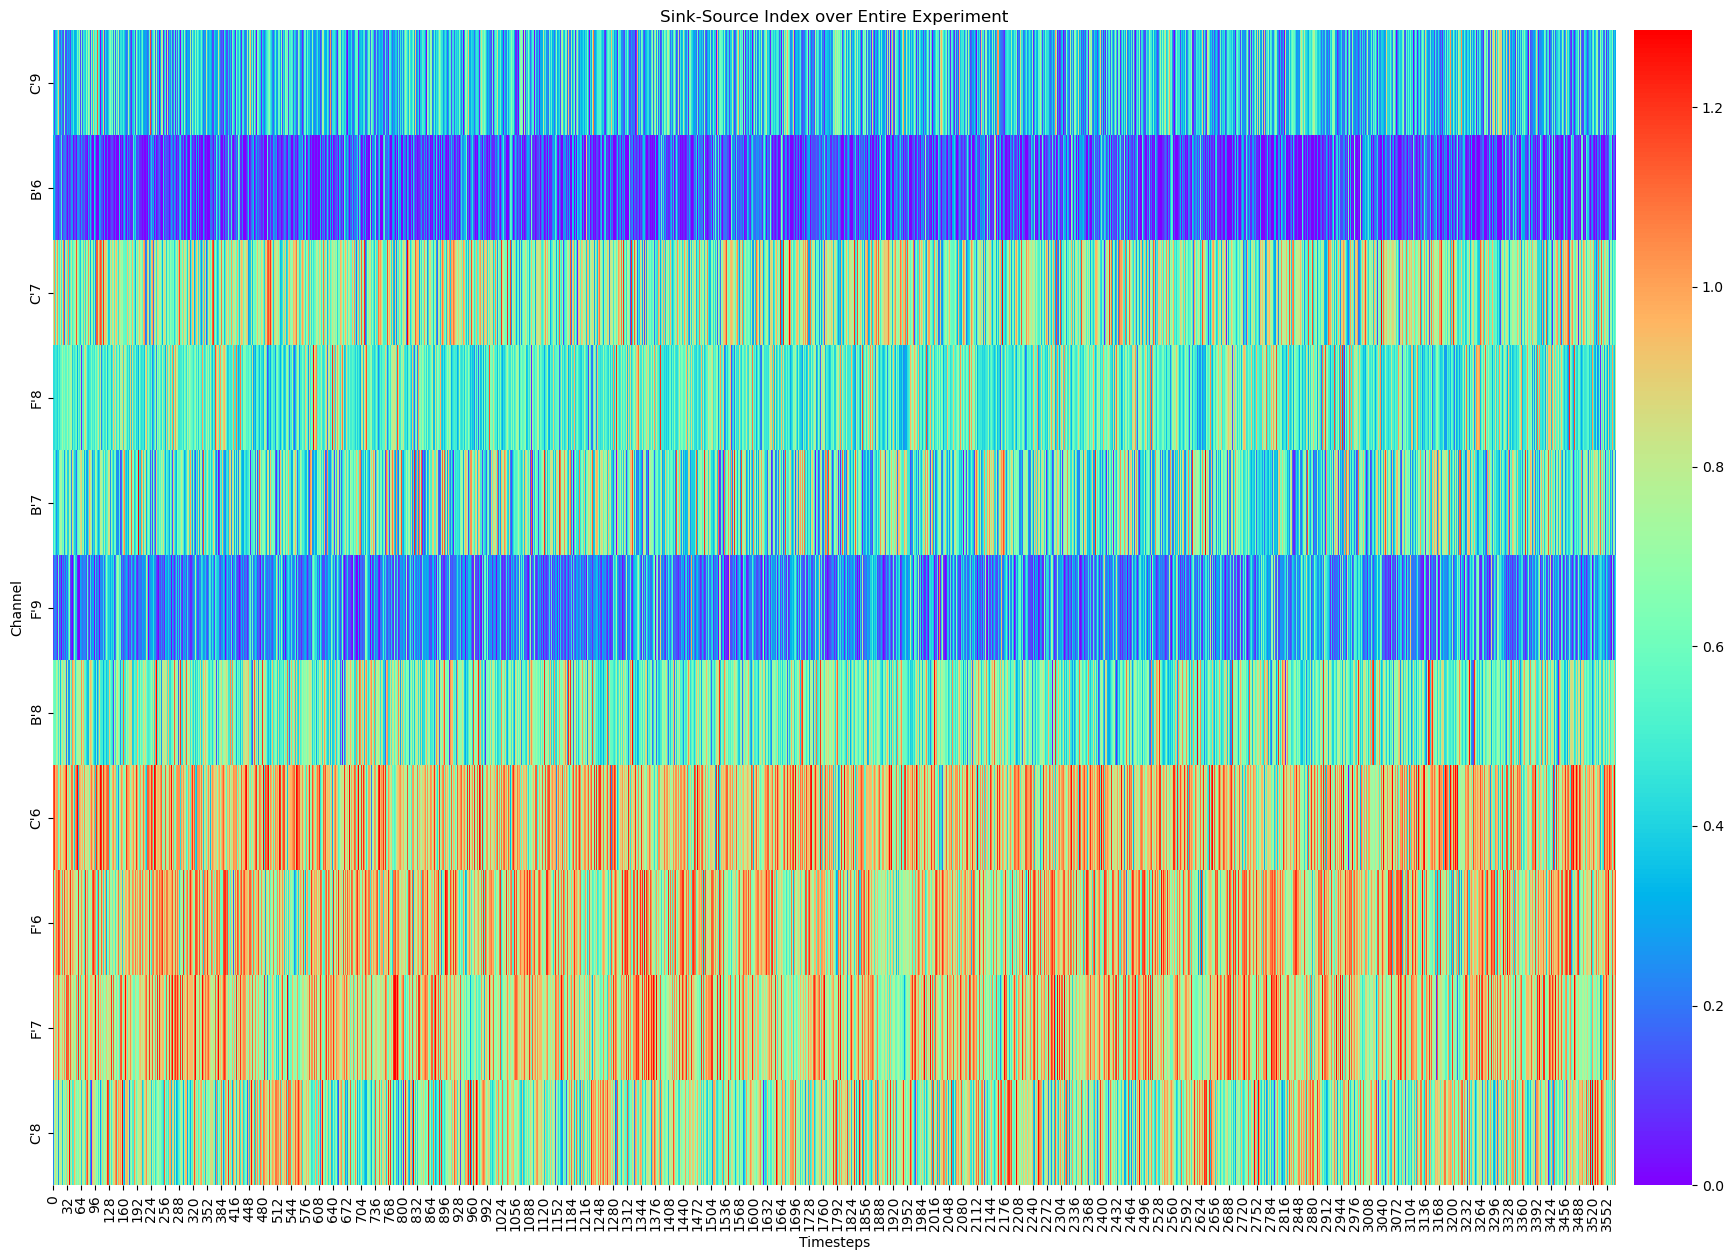

In [43]:
fig, ax = plt.subplots(1,1,figsize=(24, 15))
sns.heatmap(SI_wins_sorted, yticklabels=labels_sort, cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={"pad": 0.01})
ax.set_xlabel('Timesteps')
ax.set_ylabel('Channel')
ax.set_title('Sink-Source Index over Entire Experiment')
# for index in rescaled_start_trial_index_per_trial:
#     ax.axvline(index, color = 'black', alpha=1, ls = '-')

# Compute Spectral Entropy

In [22]:
from tqdm.auto import tqdm
import torch

/home/dwang/miniconda3/envs/ncsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def _xlogx(x, base=2):
    """Returns x log_b x if x is positive, 0 if x == 0, and np.nan
    otherwise. This handles the case when the power spectrum density
    takes any zero value.
    """
    x = np.asarray(x)
    xlogx = np.zeros(x.shape)
    xlogx[x < 0] = np.nan
    valid = x > 0
    xlogx[valid] = x[valid] * np.log(x[valid]) / np.log(base)
    return xlogx

In [24]:

def compute_spectrogram(input_vector, sample_rate, window_size=None, hop_size=None, n_fft=None, window_type="hann"):
    """
    Computes the spectrogram using PyTorch on a GPU, considering the inputs similar to the scipy.signal.periodogram function,
    and also returns the frequency axis.

    Parameters:
    ----------
    input_vector : list or np.array
        The input signal or data sequence for which to compute the spectrogram.
    sample_rate : int
        The sample rate of the input vector, measured in Hertz (Hz).
    window_size : int, optional
        The size of the analysis window used in the FFT computation.
        This parameter determines the size of the analysis window used in the
        FFT computation. It specifies the number of samples in each window. A larger
        window size provides better frequency resolution but sacrifices time resolution.
        It is usually a power of 2 for efficient FFT computation.
    hop_size : int, optional
        The number of samples between the start of one window and the start
        of the next window in the spectrogram.
        A smaller hop size leads to a higher overlap, while a larger hop size
        reduces the overlap. Increasing the overlap can improve time resolution
        by reducing the spacing between consecutive time frames in the spectrogram.
        However,it also increases computational complexity. A smaller hop size
        increases the time resolution but may introduce more spectral leakage.
    n_fft : int, optional
        The number of FFT points or bins used in the FFT computation.
        The parameter specifies the number of FFT points or bins used in the FFT
        computation. It determines the frequency resolution of the resulting spectrogram.
        More FFT points yield finer frequency resolution but increase computational complexity.
        Typically, n_fft is also a power of 2 for efficient FFT computation.
    window_type : str, optional
        The type of window function to be used. Available options: "hann" (default), "hamming",
        "boxcar", "bartlett", "blackman", "kaiser".


    Returns:
    -------
    power_spectrogram : np.array
        The power spectrogram computed using the STFT.
    time_axis : np.array
        The time axis corresponding to the spectrogram. It provides the time points at which the spectrogram is computed.
    frequency_axis : np.array
        The frequency axis corresponding to the spectrogram. It provides the frequencies at which the power spectrum is
        calculated.

    Example usage I (General):
    --------------
    >>> input_vector = [...]  # Your input vector
    >>> sample_rate = 44100  # Sample rate of the input vector
    >>> window_size = 1024  # Size of the analysis window (in samples)
    >>> hop_size = 512  # Hop size (in samples)
    >>> n_fft = 1024  # Number of FFT bins
    >>> time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector, sample_rate, window_size, hop_size, n_fft)

    Example usage II (Synthetic signal):
    --------------
    >>>  # Generate a sample signal
    >>>  fs = 2  # Sample rate (Hz)
    >>>  t = np.arange(0, 180, 1/fs)  # Time vector
    >>>  f1 = 0.8  # Frequency of the signal
    >>>  sig = np.sin(2 * np.pi * f1 * t)
    >>>  time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=sig, sample_rate=2, window_type="hann")
    >>>
    >>>  # Plot the spectrogram
    >>>  plt.plot(frequency_axis, power_spectrogram)
    >>>  plt.xlabel('Frequency')
    >>>  plt.ylabel('Power Spectrum')
    >>>  plt.show()

    Example usage III (Synthetic signal):
    --------------
    >>> fs = 10e3
    >>> N = 1e5
    >>> amp = 2 * np.sqrt(2)
    >>> noise_power = 0.01 * fs / 2
    >>> time = np.arange(N) / float(fs)
    >>> mod = 500*np.cos(2*np.pi*0.25*time)
    >>> carrier = amp * np.sin(2*np.pi*3e3*time + mod)
    >>> rng = np.random.default_rng()
    >>> noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
    >>> noise *= np.exp(-time/5)
    >>> x = carrier + noise
    >>>
    >>> # frequency_axis, power_spectrogram = compute_spectrogram(input_vector=sig, sample_rate=2, window_type="hann")
    >>> time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=x, sample_rate=fs, window_size=3*60, hop_size=2*60, n_fft=3*60, window_type="hann")
    >>>
    >>> # Plot the computed spectrogram
    >>> fig, ax = plt.subplots(figsize=(10,6))
    >>> plt.pcolormesh(time_axis, frequency_axis, power_spectrogram, shading='gouraud', cmap="turbo")
    >>> ax.tick_params(axis='x', rotation=45, labelsize=13)
    >>> ax.tick_params(axis='y', rotation=45, labelsize=13)
    >>> ax.set_xlabel("Time [sec]", fontsize=15)
    >>> ax.set_ylabel("Frequency [Hz]", fontsize=15)
    >>> ax.grid(False)
    >>> plt.show()
    """

    def boxcar_window(window_size):
        # Create a tensor of ones with the desired window size
        window = torch.ones(window_size)
        return window

    # Handle input variables
    if window_size == None:
        # If None the length of x will be used.
        window_size = len(input_vector)
    if hop_size == None:
        # If None the length of x will be used.
        hop_size = len(input_vector)
    if n_fft is None:
        # If None the length of x will be used.
        n_fft =  len(input_vector)

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert input vector to a PyTorch tensor and move it to the GPU
    input_tensor = torch.tensor(input_vector, dtype=torch.float64).to(device)

    # Print the device and tensor contents
    if device.type == "cuda":
        print("INFO: GPU available. Tensor moved to GPU.")
    else:
        print("INFO: No GPU available. Tensor remains on CPU.")

    # Compute the STFT (Short-Time Fourier Transform)
    if window_type == "boxcar":
        window = boxcar_window(window_size)
    else:
        window = getattr(torch, f"{window_type}_window")(window_size)
    spectrogram = torch.stft(input_tensor, n_fft=n_fft, hop_length=hop_size, win_length=window_size,
                             window=window.cuda(), center=False, return_complex=True, onesided=True,
                             normalized=True)

    # Convert complex spectrogram to magnitude spectrogram
    magnitude_spectrogram = torch.abs(spectrogram)

    # Compute the power spectrogram
    # power_spectrogram = magnitude_spectrogram.pow(2)
    power_spectrogram = magnitude_spectrogram ** 2

    # Scale the spectrogram by the window energy
    # power_spectrogram *= window_size / float(hop_size * sample_rate)

    # Compute the time axis
    total_time = len(input_vector) / sample_rate
    num_segments = power_spectrogram.shape[1]
    if num_segments == 1:
        time_axis = torch.zeros(1)
    else:
        time_step = total_time / (num_segments - 1)
        time_axis = torch.arange(0, total_time + time_step, time_step)

    # Compute the frequency axis
    frequency_axis = torch.linspace(0, sample_rate/2, n_fft//2 + 1)

    # Convert output vector to a Numpy array and move it to the CPU
    if device.type == "cuda":
        power_spectrogram = power_spectrogram.cpu().detach().numpy()
    time_axis = time_axis.detach().numpy()
    frequency_axis = frequency_axis.detach().numpy()

    return time_axis, frequency_axis, power_spectrogram

In [25]:
minu = 1 # minutes of SItime_t to compute entropy
n = int(minu*60/winSize_sec)

varSE_all = np.zeros((nCh,nWin))

pbar = tqdm(total=nCh, desc='Percentage of entropies computed', position=0) # Daniel's suggestion
for chi in range(nCh):
    pbar.set_postfix({'Channel': selected_ch_names[chi]})

    SI_channel = SI_wins[chi,:]

    SI_channel = np.concatenate((np.zeros((n)), SI_channel))

    time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=SI_channel, sample_rate=2, window_size=n, hop_size=1, n_fft=n, window_type="boxcar")

    power_spectrogram = power_spectrogram[:,:-1]

    psd = power_spectrogram[1:,:] # exclude DC
    with np.errstate(divide='ignore', invalid='ignore'):
        psd_norm = psd / psd.sum(axis=0, keepdims=True)
        psd_norm[psd_norm == np.inf] = 0
    se = -_xlogx(psd_norm).sum(axis=0) # Sum over all frequencies
    se /= np.log2(psd_norm.shape[0])

    varSE_all[chi, :] = se

    pbar.update(1) # DONE WITH COMPUTATION FOR CHANNEL {chi}


Percentage of entropies computed:   0%|          | 0/11 [00:00<?, ?it/s, Channel=B'8]

/home/dwang/miniconda3/envs/ncsl/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Percentage of entropies computed:  91%|█████████ | 10/11 [00:01<00:01,  1.18s/it, Channel=F'6]

INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.
INFO: GPU available. Tensor moved to GPU.


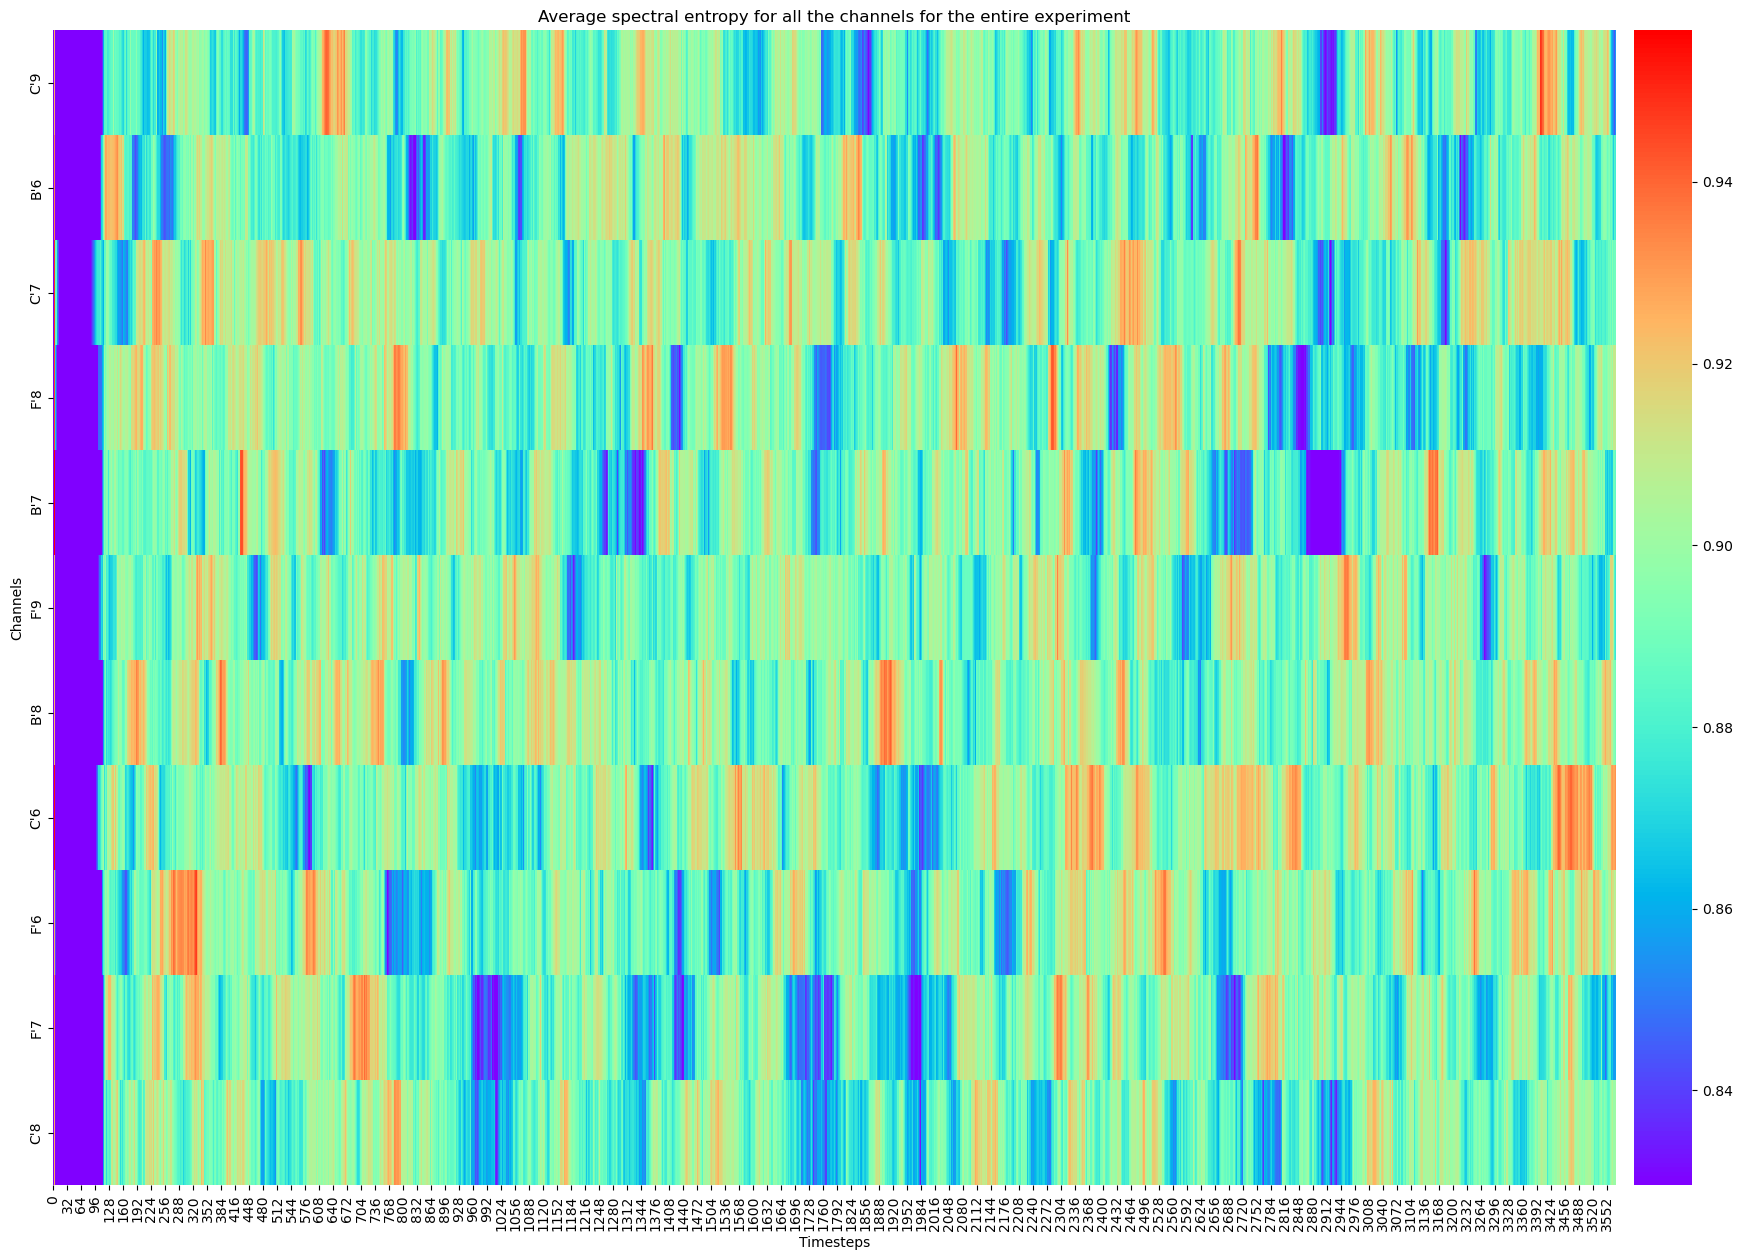

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

minval = np.min(varSE_all[np.nonzero(varSE_all)])
maxval = np.max(varSE_all[np.nonzero(varSE_all)])

fig, ax = plt.subplots(figsize=(24, 15))
sns.heatmap(varSE_all, yticklabels=labels_sort, cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={"pad": 0.01}, vmax=np.median(varSE_all)+1*np.std(varSE_all), vmin=np.median(varSE_all)-1*np.std(varSE_all))

# im=ax.imshow(varSE_all, aspect="auto", interpolation='nearest', cmap='rainbow_r', vmax=np.median(varSE_all)+1*np.std(varSE_all), vmin=np.median(varSE_all)-1*np.std(varSE_all))

# for i, index in enumerate(rescaled_start_trial_index_per_trial):
#     if y[i] == 1:
#         c = "red"
#     else:
#         c = "black"
#     ax.axvline(index, color = c, alpha=1, ls = '-', linewidth=1)

ax.set_title("Average spectral entropy for all the channels for the entire experiment")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Channels")

plt.show()

In [27]:
varSE_all.shape

(11, 3572)

In [28]:
def kernelModeEstimate(data):

    from scipy.stats import gaussian_kde

    modeEst = np.array([])
    data = np.squeeze(data) # for (1,N) or (N,1) cases

    if np.ndim(data) == 1:
        kde = gaussian_kde(data)
        xden = np.linspace(np.min(data), np.max(data), int(10e4))
        fden = kde.evaluate(xden)
        modeEst = xden[np.argmax(fden)]
    elif np.ndim(data) == 2:
        modeEst = np.zeros(data.shape[1])
        for ll in range(data.shape[1]):
            kde = gaussian_kde(data[:, ll])
            xden = np.linspace(np.min(data[:, ll]), np.max(data[:, ll]), int(10e4))
            fden = kde.evaluate(xden)
            modeEst[ll] = xden[np.argmax(fden)]
    elif np.ndim(data) == 3:
        modeEst = np.zeros((data.shape[0], data.shape[1]))
        for ll in range(data.shape[0]):
            for kk in range(data.shape[1]):
                kde = gaussian_kde(data[ll, kk, :])
                xden = np.linspace(np.min(data[ll, kk, :]), np.max(data[ll, kk, :]), int(10e4))
                fden = kde.evaluate(xden)
                modeEst[ll, kk] = xden[np.argmax(fden)]
            print('.', end='')
        print()

    return modeEst

In [29]:
ent_sum = np.sum(varSE_all, axis=0) / nCh
ents = ent_sum[n:]
ents_med = kernelModeEstimate(ents)
print(ents_med) # you can use this number later

0.8950065263429215


In [30]:
rescaled_start_trial_index_per_trial = rescaled_start_trial_index_per_trial - n
# rescaled_start_trial_index_per_trial = rescaled_start_trial_index_per_trial[rescaled_start_trial_index_per_trial >= 0]

Text(0, 0.5, 'Average spectral entropy')

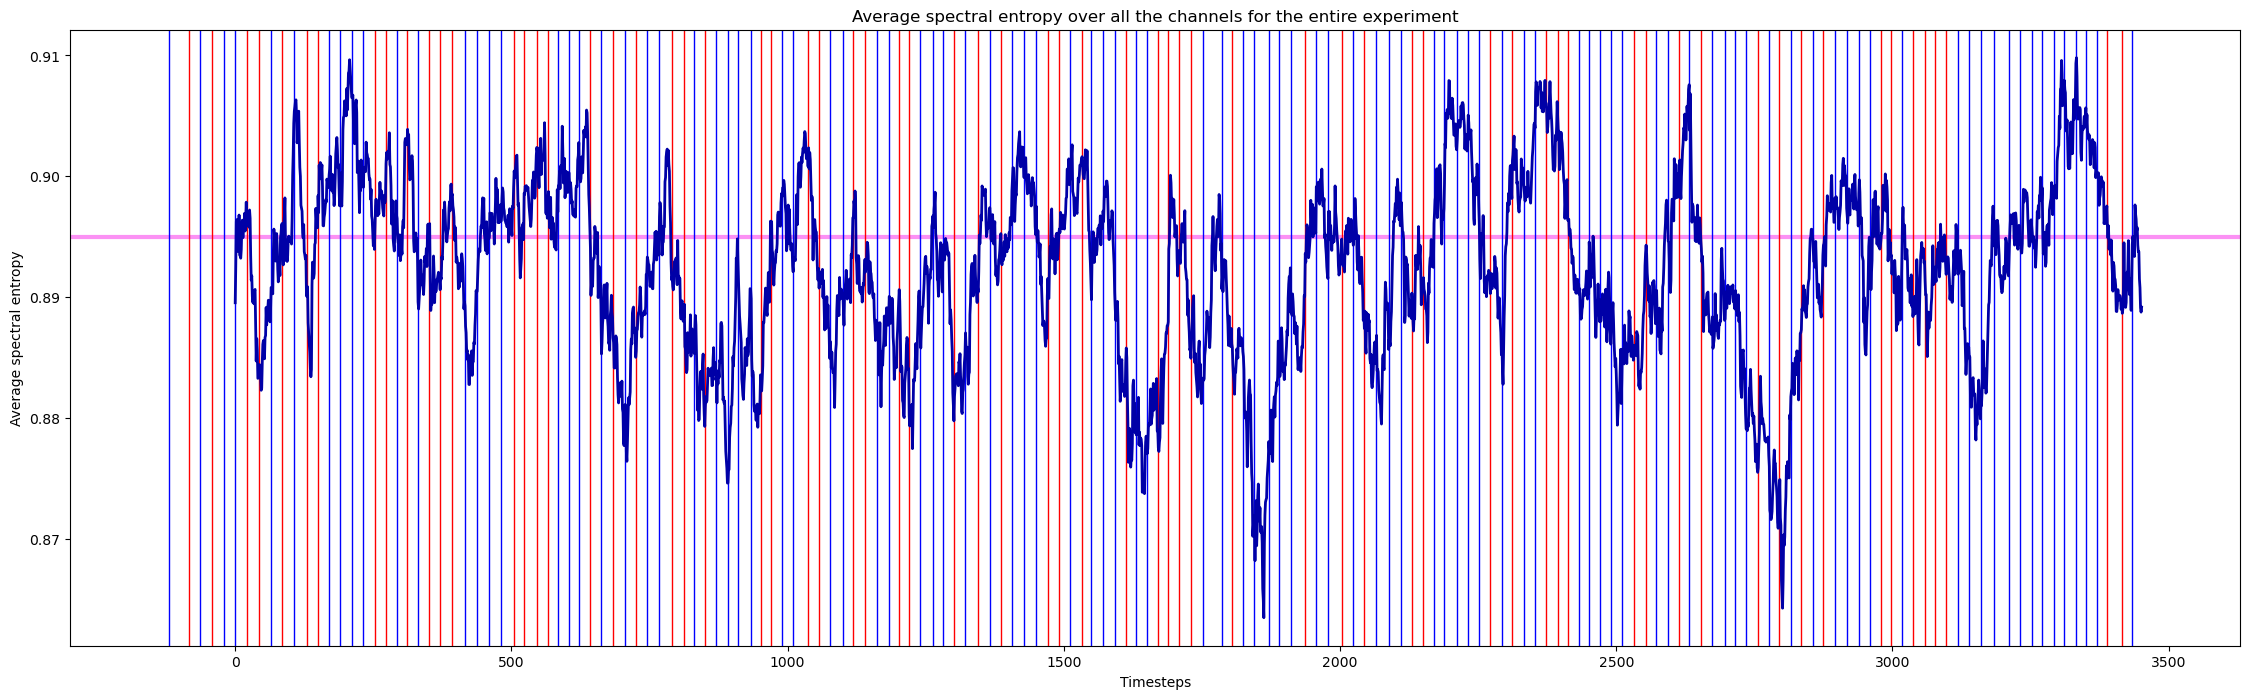

In [40]:
ent_sum = np.sum(varSE_all, axis=0) / nCh
ents = ent_sum[n:]

# ents = np.concatenate((np.zeros(n), ents))
fig, ax = plt.subplots(1,1,figsize=(28,8))

t_W = np.arange(0, len(ents), 1)

ax.axhline(ents_med, c='#FA6DF1', alpha=.75, label=f"Baseline", linestyle='-', linewidth=3)
for i, index in enumerate(rescaled_start_trial_index_per_trial):
    if y[i] == 1:
        c = "red"
    # elif subject_cards[i] == 10:
    #     c = "red"
    else:
        c = "blue"
    ax.axvline(index, color = c, alpha=1, ls = '-', linewidth=1)
ax.plot(t_W, ents, label=f'Average spectral entropy ents\nover all the channels', c='#0000a7', linewidth=2)
ax.set_title("Average spectral entropy over all the channels for the entire experiment")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Average spectral entropy")

In [32]:
ents_high_bet = []
ents_low_bet = []

for trial in range(len(y)):
    start_index = rescaled_start_trial_index_per_trial[trial]
    
    if trial == len(y)-1:
        end_index = len(ents)
    else:
        end_index = rescaled_start_trial_index_per_trial[trial+1]

    if start_index < 0:
        start_index = 0
    if end_index < 0: 
        end_index = 0
    
    if y[trial] == 1:
        ents_high_bet.append(ents[start_index:end_index].mean())
    else:
        ents_low_bet.append(ents[start_index:end_index].mean())

/tmp/ipykernel_2230105/1440225484.py:20: RuntimeWarning: Mean of empty slice.
  ents_low_bet.append(ents[start_index:end_index].mean())
/home/dwang/miniconda3/envs/ncsl/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2230105/1440225484.py:18: RuntimeWarning: Mean of empty slice.
  ents_high_bet.append(ents[start_index:end_index].mean())


In [36]:
ents_high_bet = np.asarray(ents_high_bet)
ents_high_bet = ents_high_bet[~np.isnan(ents_high_bet)]

ents_low_bet = np.asarray(ents_low_bet)
ents_low_bet = ents_low_bet[~np.isnan(ents_low_bet)]